# Equal-sized Bins Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
# Path to the CSV file containing the collected splats.
CSV_FILE_PATH = "data/collected_splats.csv"

# Number of bins to use.
NUMBER_OF_BINS = 5

In [2]:
import numpy as np
import polars as pl

from constants import IMAGE_HEIGHT, IMAGE_WIDTH

## Load Data From CSV

In [3]:
# Define the column names.
column_names = [f"gaussian_{i}_{part}" for i in range(500) for part in
                ["alpha", "depth", "color_r", "color_g", "color_b"]]
column_names = ["sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                "background_b"] + column_names

# Define schema.
schema_dict = {name: pl.Float32 for name in column_names}
schema_dict["sample_index"] = pl.UInt32
schema_dict["background_r"] = pl.UInt8
schema_dict["background_g"] = pl.UInt8
schema_dict["background_b"] = pl.UInt8
schema = pl.Schema(schema_dict)

In [4]:
# Load data.
data = pl.scan_csv(CSV_FILE_PATH, schema=schema)

## Extract the Splats from the data

In [5]:
# Collect the raw splats.
raw_splats = data.select(
    pl.all().exclude("sample_index", "out_color_r", "out_color_g", "out_color_b", "background_r", "background_g",
                     "background_b")).collect().to_numpy()

# Reshape into splats table per pixel.
splats = raw_splats.reshape((IMAGE_HEIGHT * IMAGE_WIDTH, raw_splats.shape[1] // 5, 5))

# Cluster Splats
- Create N bins from the minimum non-zero depth to the maximum depth.
- For each pixel, collect splats into bins based on their depth.
- In each bin, sum the premultiplied colors and sum the alphas.

In [6]:
# Compute the minimum and maximum depth of the image.
depth_values = splats[:, :, 1]
depth_values = depth_values[depth_values > 0]
min_depth = np.min(depth_values)
max_depth = np.max(depth_values)

print(f"Min depth: {min_depth}, Max depth: {max_depth}")
print(f"Each bin will be {(max_depth - min_depth) / NUMBER_OF_BINS} units wide.")

Min depth: 1.2029399871826172, Max depth: 11.86460018157959
Each bin will be 2.1323320865631104 units wide.


In [7]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [27]:
def collect_splats(pixel_splats, number_of_bins, min_bin_depth, max_bin_depth):
    """Cluster splats into bins based on their depth."""
    
    # Initialize clustering 2D list: cluster -> [[alpha, *color], ...].
    pixel_clustering = [[] for _ in range(number_of_bins)]

    # Loop through each splat.
    for splat in pixel_splats:
        # Skip transparent splats.
        if splat[0] == 0:
            continue

        # Compute the bin index.
        bin_index = int((splat[1] - min_bin_depth) / (max_bin_depth - min_bin_depth) * (number_of_bins - 1))
        
        # Add the splat to the bin.
        pixel_clustering[bin_index].append(np.concatenate(([splat[0]], splat[2:])))

    # Commutative combination of the splats in each cluster (alpha, color).
    pixel_output = np.zeros((len(pixel_clustering), 4))
    for index, cluster in enumerate(pixel_clustering):
        if not cluster:
            continue
        cluster = np.array(cluster)
        pixel_output[index, 0] = 1 - np.prod(1 - cluster[:, 0])
        alpha_sum = np.sum(cluster[:, 0])
        if alpha_sum:
            pixel_output[index, 1:] = np.sum(cluster[:, 0].reshape(-1, 1) * cluster[:, 1:], axis=0) / alpha_sum
        else:
            pixel_output[index, 1:] = np.zeros(3)

    # Return computation.
    return pixel_output

## Do the Clustering
1. Sorted splats straight from the CSV file.
2. Shuffled splats in each pixel.

In [28]:
# Cluster the splats (sorted).
clustered_splats = Parallel(n_jobs=-1)(
    delayed(collect_splats)(pixel_splats, NUMBER_OF_BINS, min_depth, max_depth) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [36]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

# Cluster shuffled splats.
cluster_shuffled_splats = Parallel(n_jobs=-1)(
    delayed(collect_splats)(pixel_splats, NUMBER_OF_BINS, min_depth, max_depth) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Bins
- Compute the color of each pixel using the clustered splats.
- Use the alpha-over blending formula with each bin from front to back.
- The color of each bin is the sum of the premultiplied colors divided by the sum of alphas.

In [30]:
def alpha_over_pixel(pixel_clusters):
    """Compute the color of each pixel using the clustered splats."""
    # Define the transmittance and pixel color for the first bin.
    transmittance = 1.0
    pixel_color = np.zeros(3)

    # Loop through remaining bins.
    for cluster_alpha, *cluster_color in pixel_clusters:
        # Skip transparent bin.
        if not cluster_alpha:
            continue
        # Exit once the transmittance is basically zero.
        if transmittance <= 0.001:
            break

        # Compute the pixel color.
        pixel_color += cluster_alpha * np.array(cluster_color) * transmittance

        # Compute the transmittance.
        transmittance *= 1 - min(1, cluster_alpha)

    # Return the computed pixel color.
    return pixel_color

## Do the Computation

In [31]:
# Sorted image.
computed_image = [alpha_over_pixel(pixel_clusters) for pixel_clusters in tqdm(clustered_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

In [37]:
# Shuffled image.
computed_shuffled_image = [alpha_over_pixel(pixel_clusters) for pixel_clusters in tqdm(cluster_shuffled_splats)]

  0%|          | 0/1051648 [00:00<?, ?it/s]

## Display the Results

In [33]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00012475802281228764..1.0811185229222602].


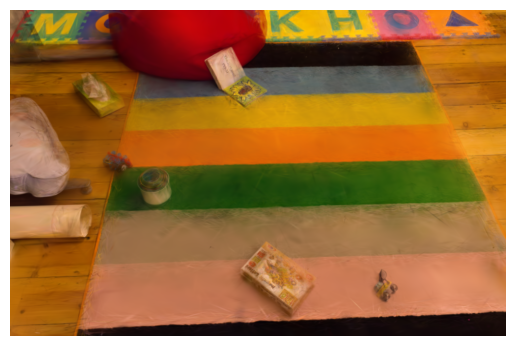

In [34]:
# Display the sorted image.
plt.imshow(np.array(computed_image).reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
plt.axis('off')
plt.savefig("output/binned_clustering_sorted.png", bbox_inches="tight", pad_inches=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00012475802281228764..1.0811184037267907].


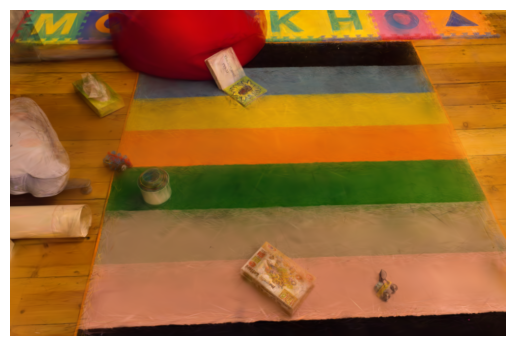

In [38]:
# Display the shuffled image.
plt.imshow(np.array(computed_shuffled_image).reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
plt.axis('off')
plt.savefig("output/binned_clustering.png", bbox_inches="tight", pad_inches=0)
